### Manhatten Plot for example cluster

including:
* for each egene and cluster pc:
    * nominal ps
    * lead variant for each independent signal via susie 
    * credible set via susie
* gene annotations

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

import seaborn as sns 

## Load in the data
* nominal p values for control eqtl and cluster
* susie for control eqtl and susie
* gene annotations

In [13]:
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type
chr_id = 21

pc_out_prefix=f'/home/klawren/oak/pcqtls/output/pcqtl/{tissue_id}'
e_out_prefix=f'/home/klawren/oak/pcqtls/output/control_eqtl/{tissue_id}'

In [28]:
# load nominal p value dfs

def var_pos(df):
    return df['variant_id'].str.split('_').str[1].astype(int)

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['variant_pos'] = var_pos(e_nominal_df)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_df = load_e_nominal(f'{e_out_prefix}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet')


def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['variant_pos'] = var_pos(pc_nominal_df)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str[:-4]
    pc_nominal_df['cluster_size'] = pc_nominal_df['phenotype_id'].str.split('_').str.len() - 1
    return pc_nominal_df

pc1_nominal_df = load_pc_nominal(f'{pc_out_prefix}/{tissue_id}.v8.pc_1.cis_qtl_pairs.chr{chr_id}.parquet')
pc2_nominal_df = load_pc_nominal(f'{pc_out_prefix}/{tissue_id}.v8.pc_2.cis_qtl_pairs.chr{chr_id}.parquet')

In [86]:
# load susie dfs
def get_lead_var(susie_df):
    lv = susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')
    return susie_df['cs_full_id'].map(lv['variant_id'])

def load_e_susie(path):
    e_susie_df = pd.read_csv(path, sep='      ', index_col=0)
    e_susie_df['cluster_id'] = e_susie_df['phenotype_id'].str.split('_e_').str[0]
    e_susie_df['egene_id'] = e_susie_df['phenotype_id'].str.split('_e_').str[1]
    e_susie_df['cs_full_id'] = e_susie_df['phenotype_id'].astype(str) + '_e_cs' + e_susie_df['cs_id'].astype(str) 
    e_susie_df['lead_variant'] = get_lead_var(e_susie_df)
    e_susie_df['is_lead'] = e_susie_df['variant_id'] == e_susie_df['lead_variant']
    e_susie_df['variant_pos'] = var_pos(e_susie_df)
    return e_susie_df

e_susie_df = load_e_susie(f'{e_out_prefix}/{tissue_id}.v8.cluster_genes.susie.txt')

def load_pc_susie(path):
    pc_susie_df = pd.read_csv(path, sep='\t', index_col=0)
    pc_susie_df['cluster_id'] = pc_susie_df['phenotype_id'].str.split('_pc').str[0]
    pc_susie_df['cs_full_id'] = pc_susie_df['phenotype_id'].astype(str) + '_cs' + pc_susie_df['cs_id'].astype(str)
    pc_susie_df['lead_variant'] = get_lead_var(pc_susie_df)
    pc_susie_df['is_lead'] = pc_susie_df['variant_id'] == pc_susie_df['lead_variant']
    pc_susie_df['variant_pos'] = var_pos(pc_susie_df)
    return pc_susie_df

pc1_susie_df = load_pc_susie(f'{pc_out_prefix}/{tissue_id}.v8.pc_1.susie.txt')
pc2_susie_df = load_pc_susie(f'{pc_out_prefix}/{tissue_id}.v8.pc_2.susie.txt')

In [31]:
# load gene annotations
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

# filter to just the genes in clusters on the chromosome we're considering
gene_ids = e_nominal_df['egene_id'].unique()
gid_gencode = full_gencode.set_index('transcript_id').loc[gene_ids]
gid_gencode = gid_gencode.drop_duplicates()

## Make the plot

In [278]:
def plot_manhatten_cs(cluster_id):
    gene_ids = cluster_id.split('_')


    f, ax = plt.subplots(figsize=(10, 7))

    # plotting for the eqtls
    for i in range(len(gene_ids)):
        gene_id = gene_ids[i]
        nominal_set = e_nominal_df[e_nominal_df['egene_id'] == gene_id]
        num_cs = len(e_susie_df[e_susie_df['egene_id'] == gene_id]['cs_id'].unique())
        susie_set=e_susie_df[e_susie_df['egene_id'] == gene_id]
        
        # nominal p values
        sns.scatterplot(nominal_set,
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'eqtl {gene_id} nominal p ({num_cs} signifigant)',
                        color=sns.color_palette()[i+2], 
                        s=10, 
                        linewidth=0)
        # susie credible sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie credible set',
                        color=sns.color_palette()[i+2], 
                        marker='*', 
                        s=100, 
                        linewidth=0)
        # susie lead vars sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set[susie_set['is_lead']]['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie lead variant',
                        color=sns.color_palette()[i+2], 
                        marker='X', 
                        s=300, 
                        linewidth=0)

    # plotting for the pcqtls
    for i in range(2):
        pc_nominal_df = [pc1_nominal_df, pc2_nominal_df][i]
        pc_susie_df = [pc1_susie_df, pc2_susie_df][i]

        nominal_set = pc_nominal_df[pc_nominal_df['cluster_id'] == cluster_id]
        num_cs = len(pc_susie_df[pc_susie_df['cluster_id'] == cluster_id]['cs_id'].unique())
        susie_set=pc_susie_df[pc_susie_df['cluster_id'] == cluster_id]

        # nominal p values
        sns.scatterplot(nominal_set,
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'pc{i+1}qtl nominal p ({num_cs} signifigant)',
                        color=sns.color_palette()[i], 
                        s=10, 
                        linewidth=0)
        # susie credible sets

        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie credible set',
                        color=sns.color_palette()[i], 
                        marker='*', 
                        s=100, 
                        linewidth=0)
        # susie lead vars sets
        sns.scatterplot(nominal_set[nominal_set['variant_id'].isin(susie_set[susie_set['is_lead']]['variant_id'])],
                        x='variant_pos', 
                        y='pval_nominal', 
                        ax=ax,
                        label=f'     susie lead variant',
                        color=sns.color_palette()[i], 
                        marker='X', 
                        s=300, 
                        linewidth=0)
        

    gene_df = gid_gencode.loc[gene_ids]

    ax.set(yscale='log')
    ax.invert_yaxis()

    box_width =-.03*np.log10(ax.get_ylim()[1])
    box_init=box_width
    for i in range(len(gene_df)):
        row = gene_df.iloc[i]
        ystart = 10**(box_init + 2*box_width*i)
        yend = 10**(box_init + 2*box_width*i + box_width)

        rect = patches.Rectangle((row.start,ystart), 
                                row.end-row.start, yend-ystart, 
                                facecolor=sns.color_palette()[i+2], 
                                edgecolor =sns.color_palette()[i+2]) 
        ax.add_patch(rect)

        if row.strand=='+':
            tss_start = row.start
        else:
            tss_start=row.end
        rect = patches.Rectangle((tss_start,ystart), 
                                100, yend-ystart, 
                                facecolor='none', 
                                edgecolor ='k') 
        ax.add_patch(rect)

    ax.set_ylim(10**(box_init + 2*box_width*(i+1)), ax.get_ylim()[1])
    # get labels to we can keep them the same even after adding room for the genes
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[yticks<=1])

    ax.legend()
    return ax

In [1]:
ax = plot_manhatten_cs(e_nominal_df['cluster_id'].unique()[30])
plt.show()

NameError: name 'plot_manhatten_cs' is not defined

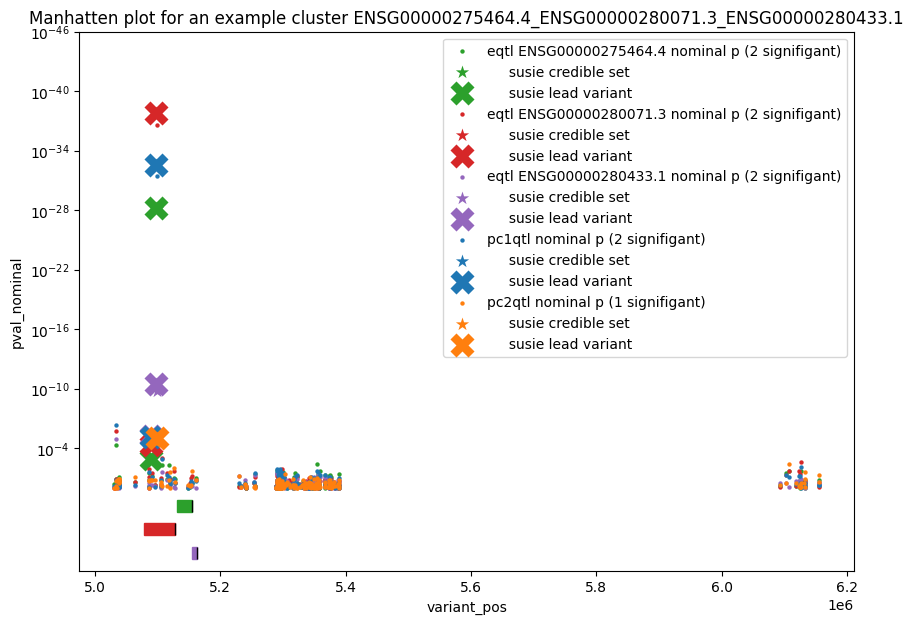

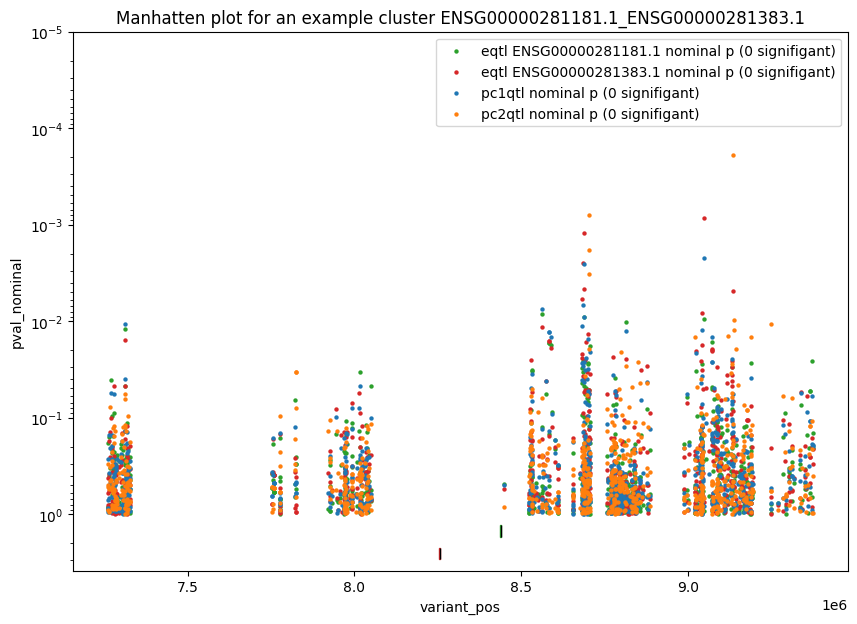

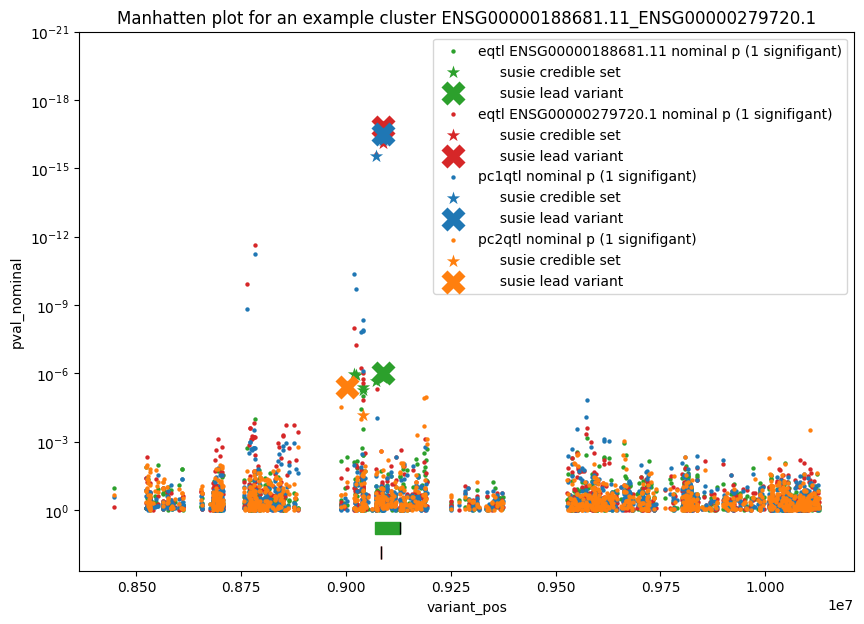

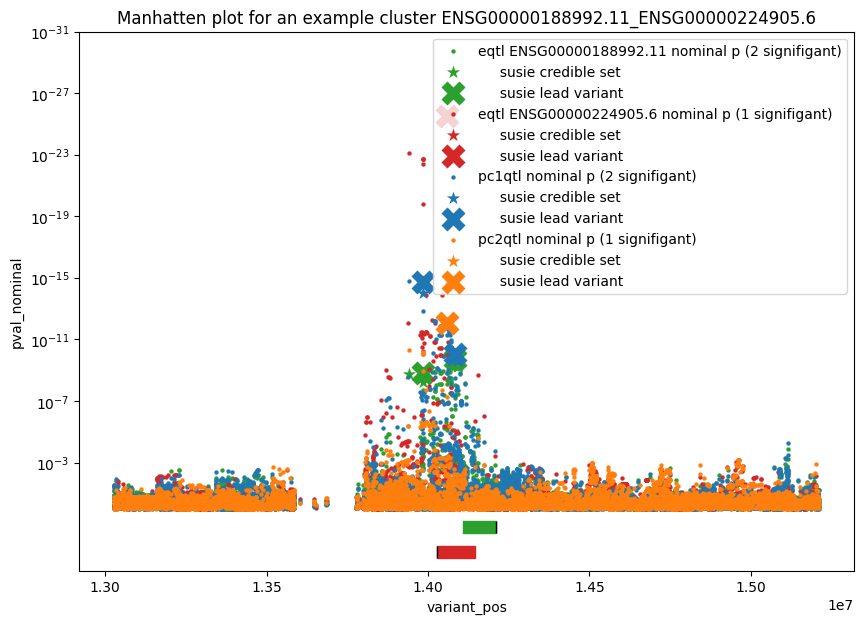

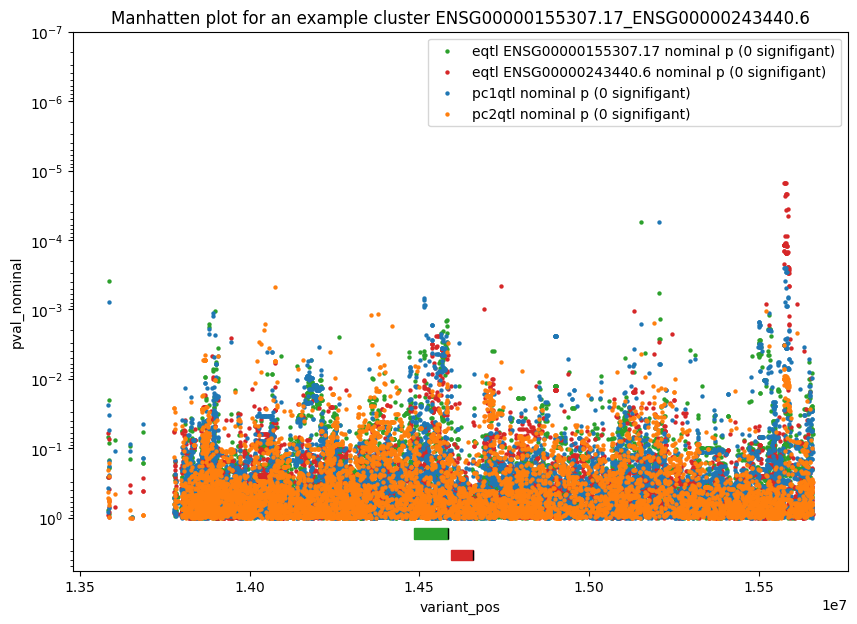

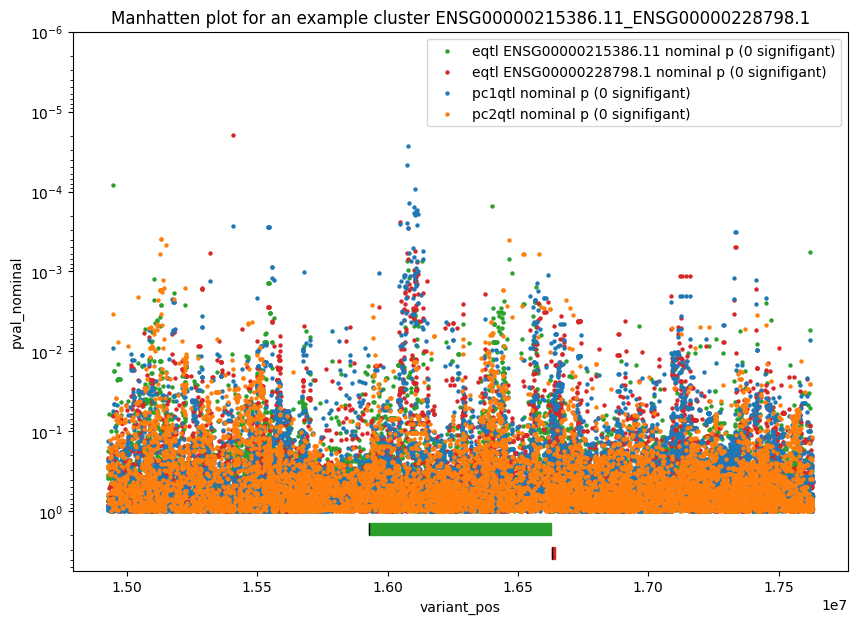

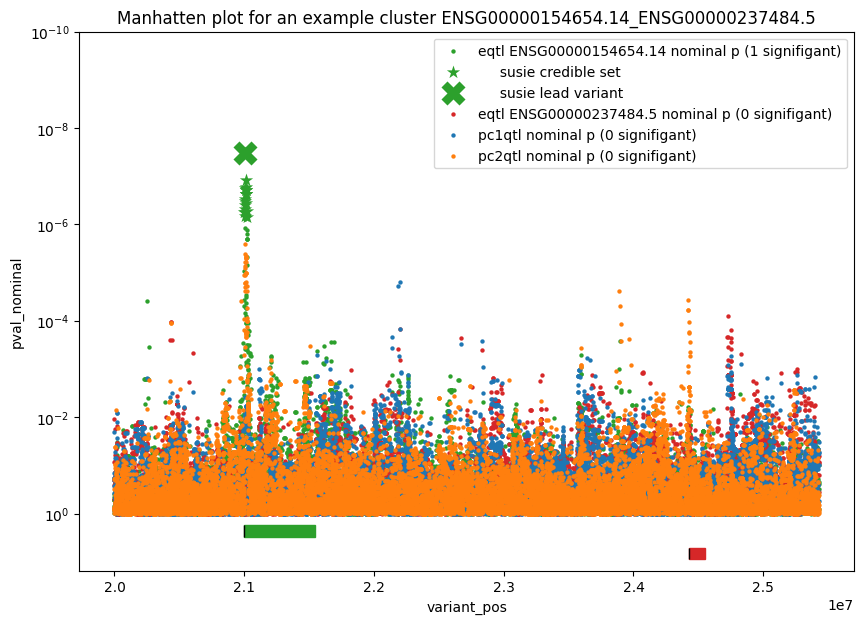

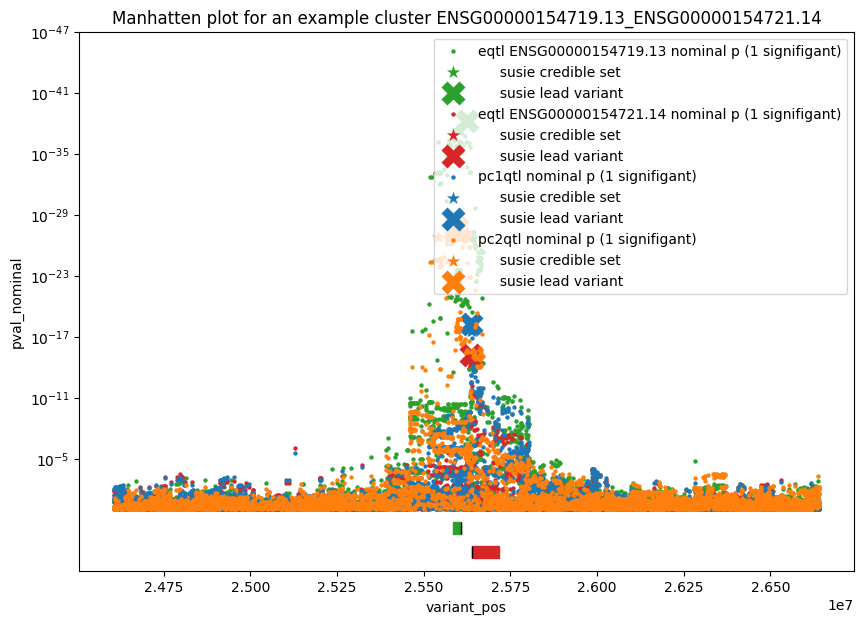

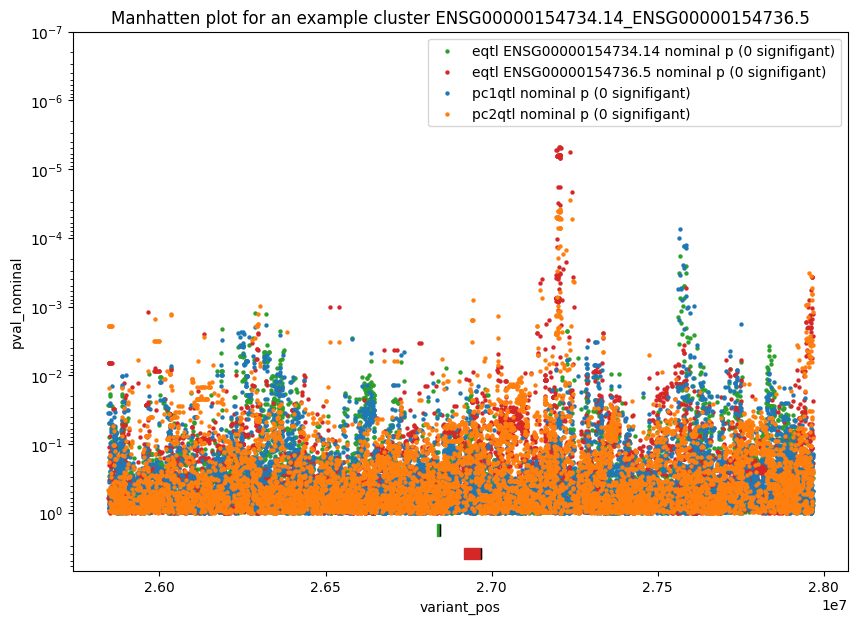

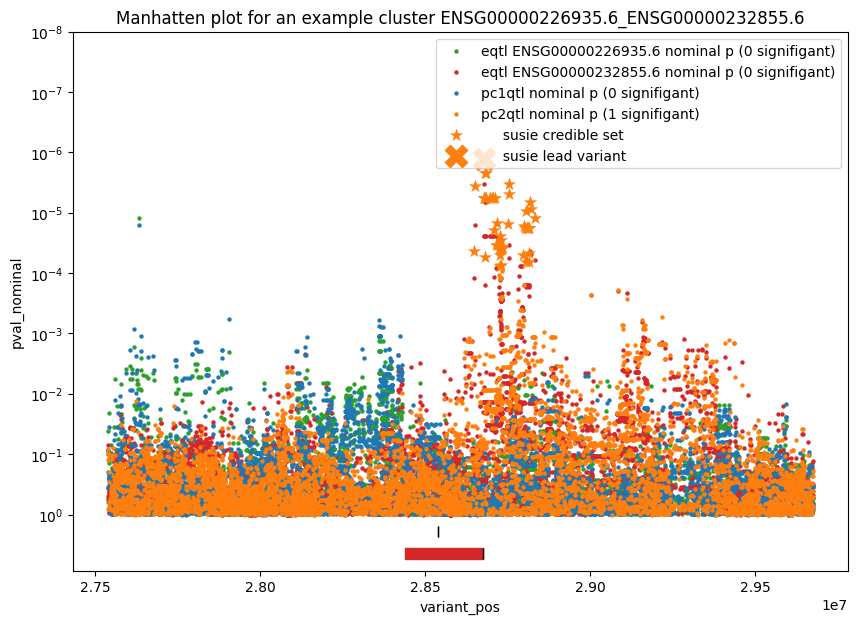

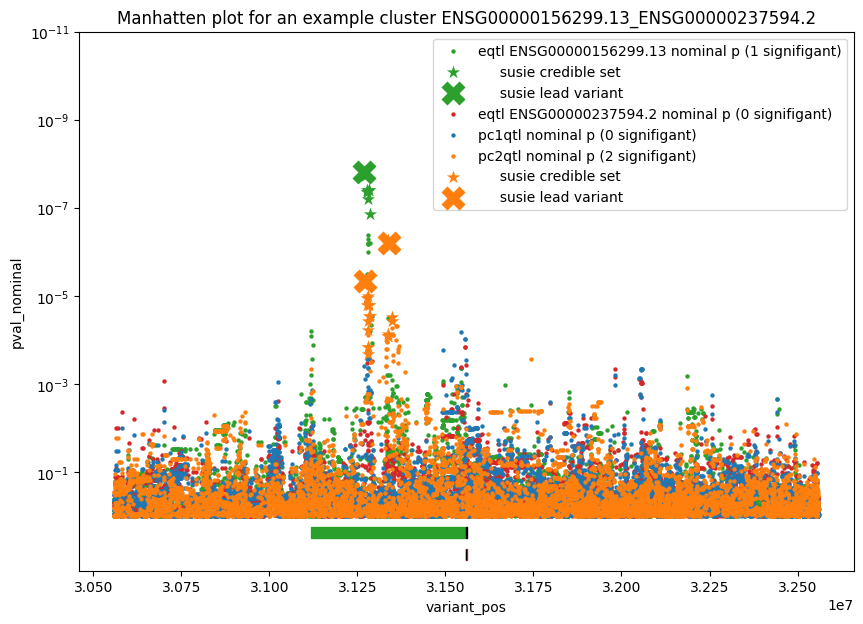

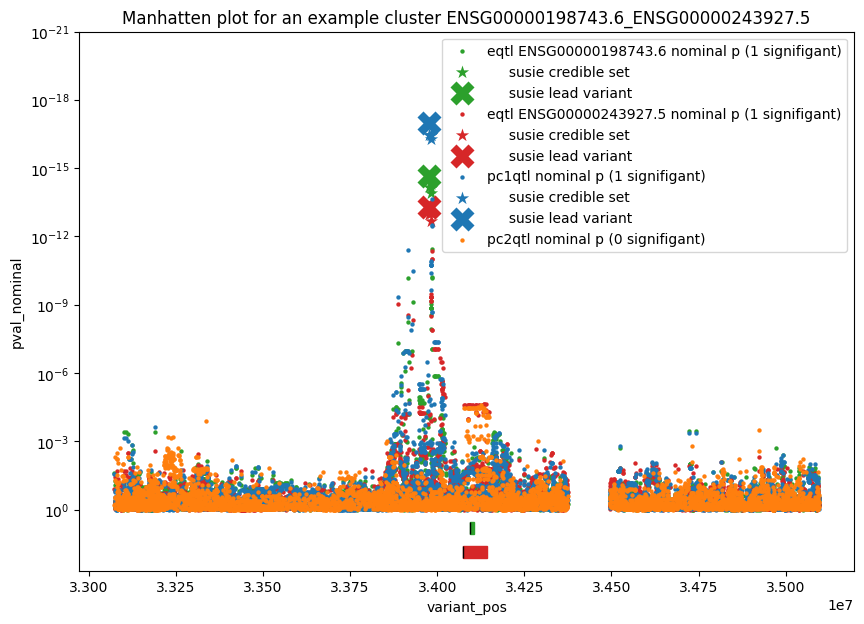

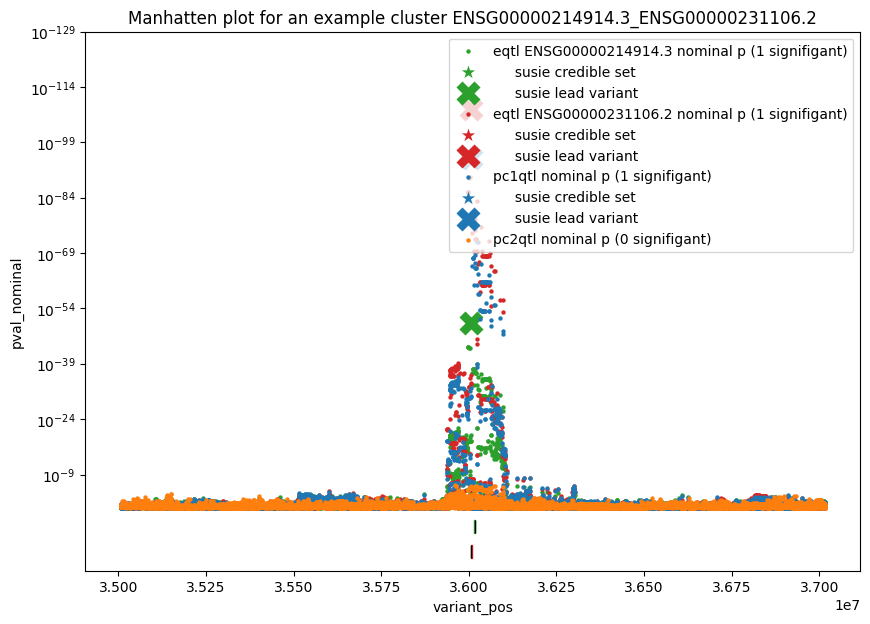

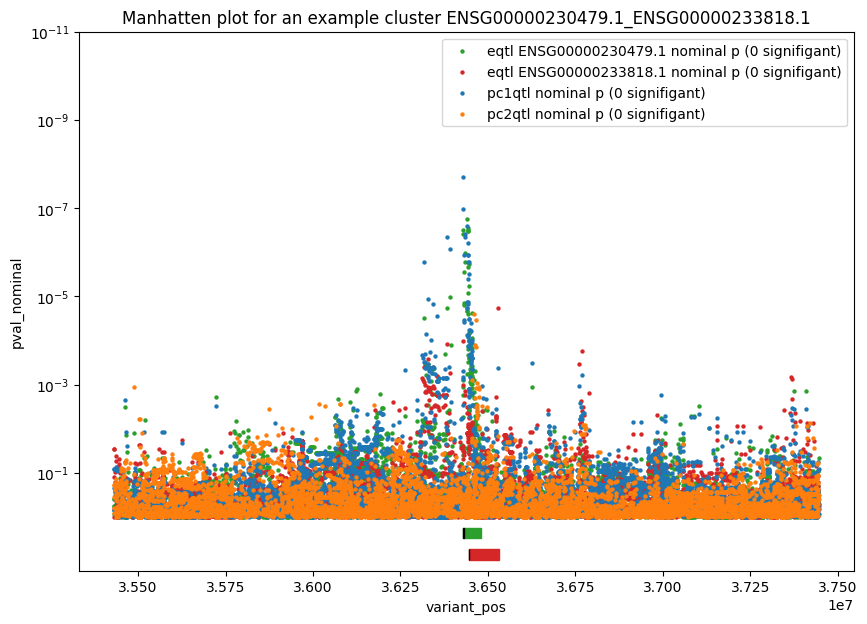

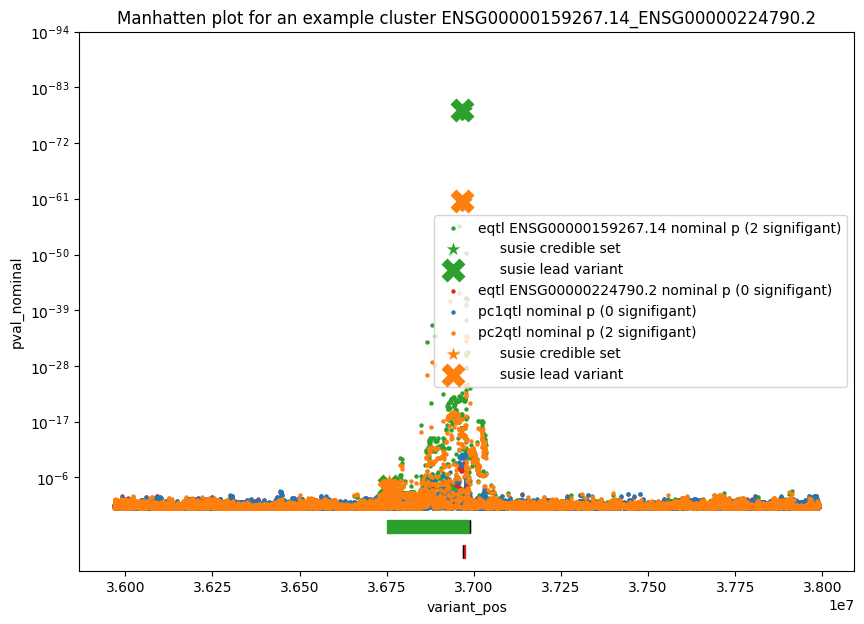

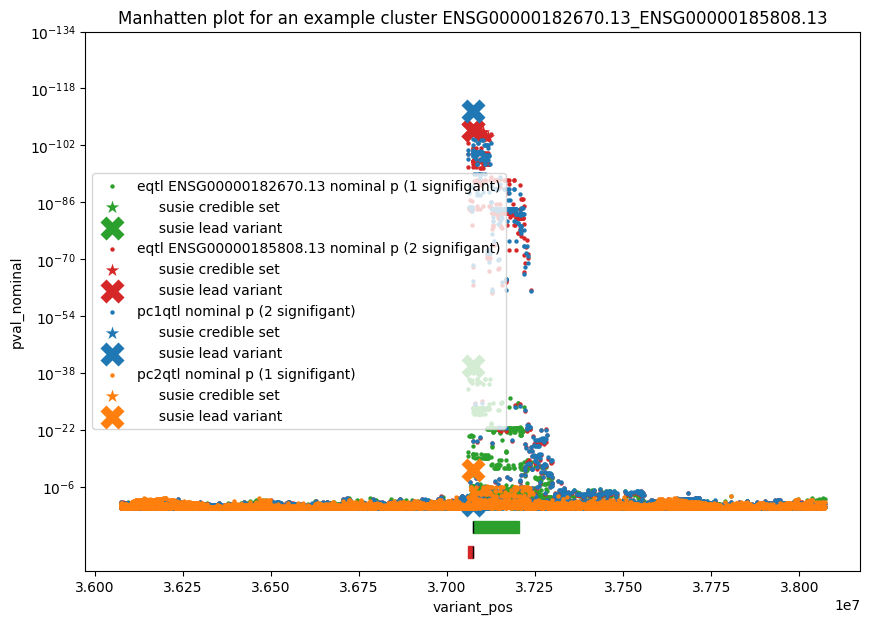

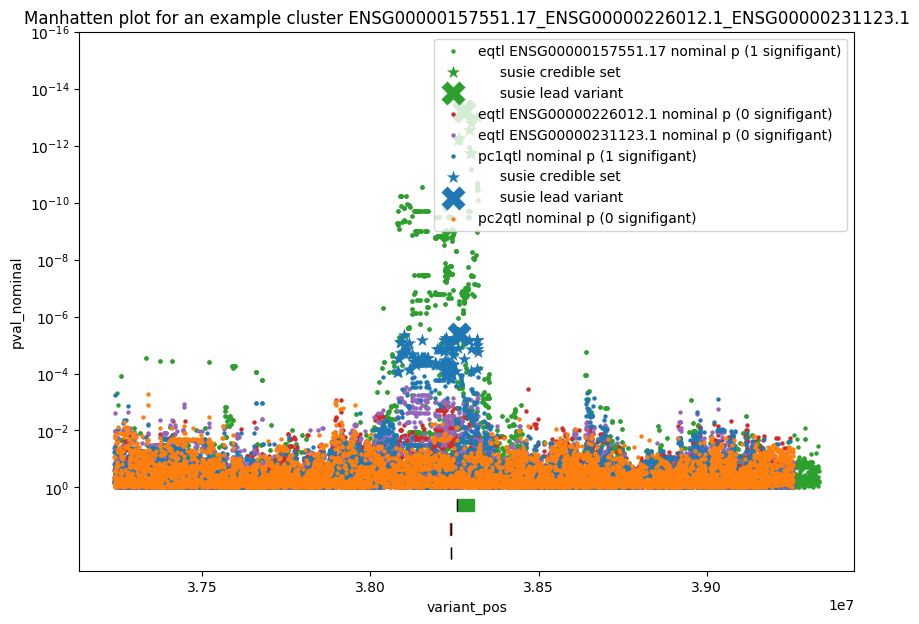

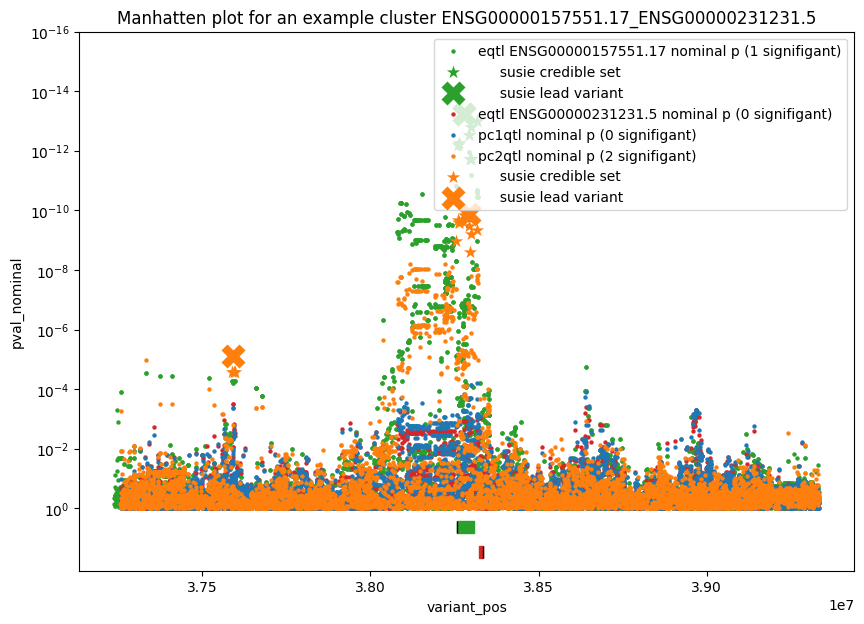

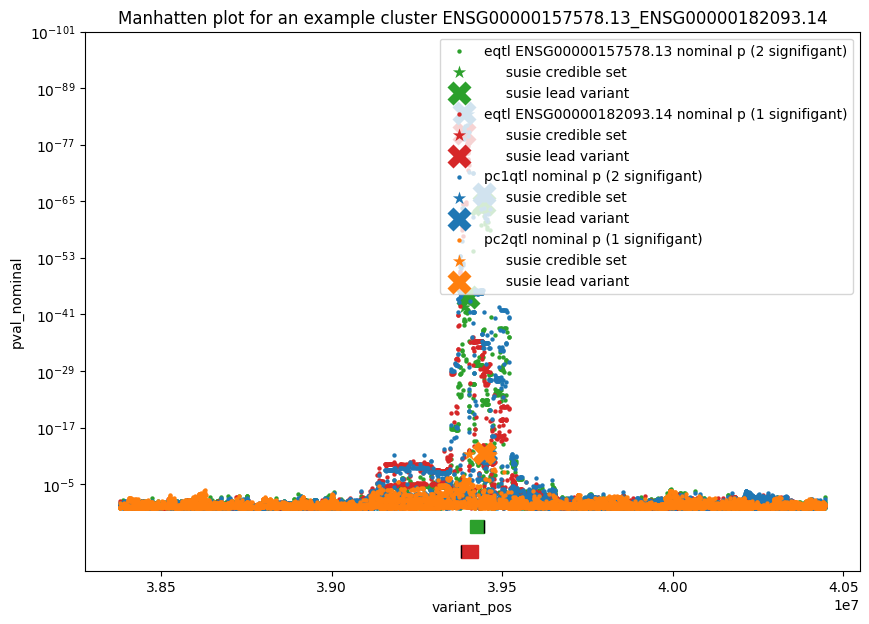

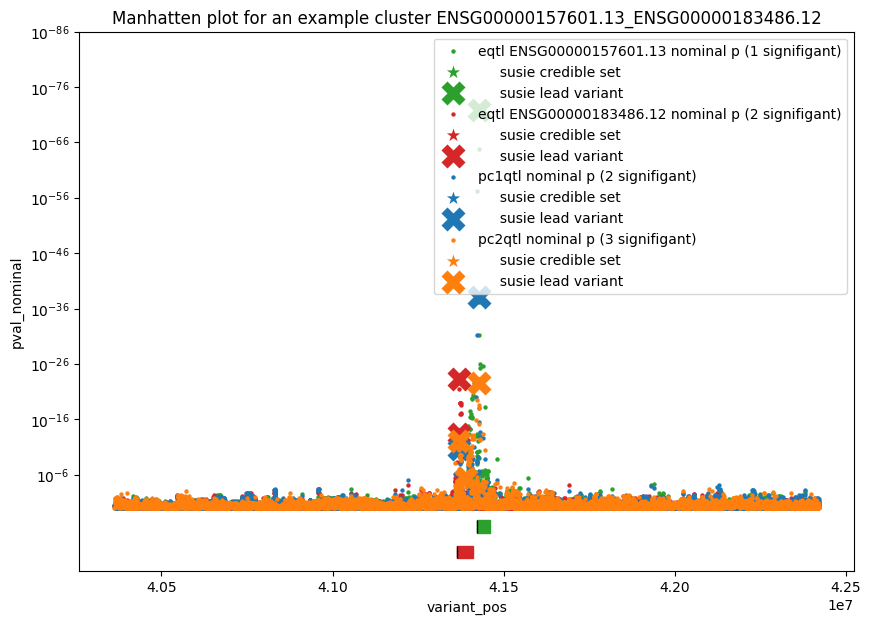

In [275]:
for i in range(20):
    cluster_id = e_nominal_df['cluster_id'].unique()[i]
    ax = plot_manhatten_cs(cluster_id)
    ax.set_title(f'Manhatten plot for an example cluster {cluster_id}')
    plt.show()    